In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 🟡 **install dependencies**


In [1]:
!pip install torchmetrics

# 🔵 **Imports**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pack_padded_sequence

import torchvision
from torchvision import transforms as T
from torchvision.utils import make_grid
from torchvision import models

from PIL import Image

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

from collections import Counter
import os

from IPython import display

In [3]:
!python --version

Python 3.10.12


In [4]:
for lib in [np, torch, torchvision, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
torch --> 2.1.0+cu118
torchvision --> 0.16.0+cu118
tqdm --> 4.66.1


# 🔵 **Utils**

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [7]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

# 🔵 **Dataset**

## 🔵 **Load Dataset**

In [8]:
#!unzip /content/drive/MyDrive/uw-madison-gi-tract-image-segmentation.zip  -d /content/

In [9]:
t = pd.read_csv('train.csv')

In [10]:
w, h = 310, 360

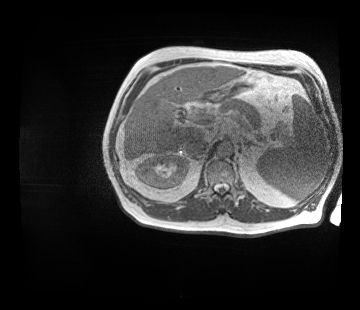

In [11]:
image = Image.open('/content/train/case78/case78_day26/scans/slice_0097_360_310_1.50_1.50.png').convert('RGB')
image

In [12]:
t

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN
115484,case30_day0_slice_0143,stomach,NaN
115485,case30_day0_slice_0144,large_bowel,NaN
115486,case30_day0_slice_0144,small_bowel,NaN


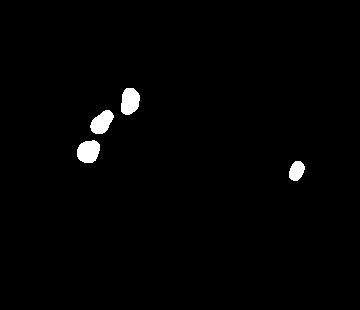

In [18]:
def rle_to_mask(rle, shape):
    mask = np.zeros(shape, dtype=np.uint8)
    rle_pairs = rle.split()
    starts = [int(x) - 1 for x in rle_pairs[0::2]]  # Subtract 1 to convert to 0-based indexing
    lengths = [int(x) for x in rle_pairs[1::2]]

    for start, length in zip(starts, lengths):
        end = start + length
        mask_flat = mask.reshape(-1)
        mask_flat[start:end] = 1

    return mask

# Example usage
rle_encoded = t['segmentation'][12000]
image_shape = (310, 360)  # Shape of the image or mask

mask = rle_to_mask(rle_encoded, image_shape)

# Save the mask as an image
mask_image = Image.fromarray(mask * 255)  # Scale the mask values from [0, 1] to [0, 255]
mask_image

In [14]:
class Clean_Data():
  def __init__(self, csv_address):

    self.csv_info = pd.read_csv(csv_address)

  def forward(self, text_case_address):

    csv_file = self.new_csv_info(text_case_address)
    return csv_file

  def rle_to_mask(self, rle : str, shape: tuple, seg_cls: int):
    mask = np.zeros(shape, dtype=np.uint8)
    rle_pairs = rle.split()
    starts = [int(x) - 1 for x in rle_pairs[0::2]]  # Subtract 1 to convert to 0-based indexing
    lengths = [int(x) for x in rle_pairs[1::2]]

    for start, length in zip(starts, lengths):
        end = start + length
        mask_flat = mask.reshape(-1)
        mask_flat[start:end] = seg_cls

    mask = torch.tensor(mask)
    return mask

  def new_csv_info(self, text_case_address):
    cases = np.loadtxt(text_case_address, dtype = str).tolist()
    address = []
    for case_n in cases:
      case_plus_day = os.listdir(f'/content/train/{case_n}/')
      for cpd in case_plus_day:
        im_add = os.listdir(f'/content/train/{case_n}/{cpd}/scans/')
        for im in im_add:
          address.append(f'/content/train/{case_n}/{cpd}/scans/{im}')

    new_csv = []
    c = 0
    for i, id in enumerate(self.csv_info['id']):
      id = id.split('_')
      for add in address:
        if f'{id[0]}_{id[1]}' in add and id[3] in add:
          cls = 0
          if str(self.csv_info['segmentation'][i]) == 'nan':
            cls = 0
          else:
            if self.csv_info['class'][i] == 'large_bowel':
              cls = 1
            elif self.csv_info['class'][i] == 'small_bowel':
              cls = 2
            else:
              cls = 3

          shape = (int(add.split('_')[4]), int(add.split('_')[3]))
          new_csv.append([add, self.csv_info['id'][i], cls, self.csv_info['segmentation'][i], shape])

    new_csv = pd.DataFrame(np.array(new_csv), columns = ['Image Address', 'ID', 'Class', 'Segmentation', 'Shape'])

    print('csv file created!')

    return new_csv

In [20]:
clean = Clean_Data('train.csv')

In [32]:
ans = input('do you have csv file for train, validation and test: (yes or no)')
if ans == 'yes':
  train_csv = pd.read_csv('train_info.csv')
  valid_csv = pd.read_csv('valid_info.csv')
  test_csv  = pd.read_csv('test_info.csv')

if ans == 'no':
  train_csv = clean.forward('train.txt')
  valid_csv = clean.forward('validation.txt')
  test_csv  = clean.forward('test.txt')

  train_csv.to_csv('train_info.csv')
  valid_csv.to_csv('valid_info.csv')
  test_csv.to_csv('test_info.csv')

do you have csv file for train, validation and test: (yes or no)yes


In [34]:
print(f'train size      : {train_csv.shape[0]}')
print(f'validation size : {valid_csv.shape[0]}')
print(f'test size       : {test_csv.shape[0]}')
print(f'total           : {train_csv.shape[0] + valid_csv.shape[0] + test_csv.shape[0]}')

train size      : 82320
validation size : 9504
test size       : 23664
total           : 115488


## 🔵 **EDA**